<h1>computational graphs</h1>

In [370]:
from casadi import *

In [371]:
x = MX.sym('x',2); # states
u = MX.sym('u'); #controls

# van der pol oscillator system (nonlinear ODE)
ode = vertcat((1 - x[1]**2)*x[0] - x[1] + u, x[0])

In [372]:
f = Function('f',[x,u],[ode])

In [373]:
f([0.2,0.8],0.1)

DM([-0.628, 0.2])

<h1>time integration method</h1>

In [377]:
T = 10 # time horizon
N = 20 # number of control intervals

In [378]:
# integrator to discretize the system
dae = {'x':x, 'p':u, 'ode':f(x,u)}
intg = integrator('intg', 'rk', dae, {'tf':T/N, 'number_of_finite_elements':4, 'simplify':True})

In [379]:
res = intg(x0=x,p=u) #evaluate with symbols
x_next = res['xf'] 

In [380]:
# Simplify API to (x,u)->(x_next)
F = Function('F',[x,u],[x_next])

In [381]:
F([0,1],0), F([0.1,0.9],0.1)

(DM([-0.494017, 0.876098]), DM([-0.307745, 0.849043]))

<h1>concept from functional programming</h1>

In [382]:
sim = F.mapaccum(N)

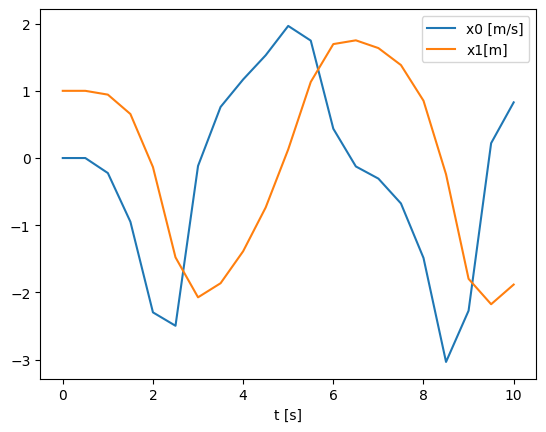

In [493]:
import matplotlib.pyplot as plt
res = sim(x0,cos(range(0,N)))
t = np.linspace(0, T, N+1)
# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((2,1)), res.toarray()), axis=1).T)
plt.legend(['x0 [m/s]', 'x1[m]'])
plt.xlabel('t [s]')
plt.show()

<h1>symbolic differentiation</h1>

In [494]:
U = MX.sym('U',N);

X1 = sim(x0, U)[0,:] #Simulate using concrete x0 and symbolic input series

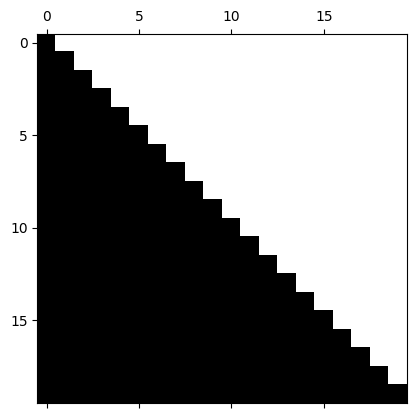

In [495]:
J = jacobian(X1, U) # jacobian of the first states wrt to input series

Jf = Function('Jf',[U],[J])
plt.spy(Jf(0))

<h1>Optimal control problem using multiple-shooting</h1>

In [496]:
opti = Opti() # Optimization problem

x = opti.variable(2,N+1) # decision variable for state trajectory
u = opti.variable(1,N)
p = opti.parameter(2,1) # parameter not optimized over

opti.minimize(sumsqr(x) + sumsqr(u)) 

for k in range(N):
    opti.subject_to(x[:,k+1]==F(x[:,k], u[:,k]))

opti.subject_to(u>=-1)
opti.subject_to(u<=1)
opti.subject_to(x[:,0]==p)

opti

Opti(Opti {
  instance #27
  #variables: 2 (nx = 62)
  #parameters: 1 (np = 2)
  #constraints: 23 (ng = 82)
  CasADi solver needs updating.
})

In [497]:
# choose a concrete solver
opti.solver('sqpmethod', {'qpsol':'qrqp'});

opti.set_value(p,[0,1]);
sol = opti.solve();

-------------------------------------------
This is casadi::QRQP
Number of variables:                              62
Number of constraints:                            82
Number of nonzeros in H:                         182
Number of nonzeros in A:                         202
Number of nonzeros in KKT:                       668
Number of nonzeros in QR(V):                     521
Number of nonzeros in QR(R):                     962
-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                              62
Number of constraints:                            82
Number of nonzeros in constraint Jacobian:       202
Number of nonzeros in Lagrangian Hessian:        182

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls    info
   0   0.000000e+00  1.00e+00  0.00e+00  0.00e+00       -  0  - 
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         1   143  2

In [512]:
t.shape

(21,)

ValueError: Size mismatch between "values" and "edges". Expected `len(values) + 1 == len(edges)`, but `len(values) = 21` and `len(edges) = 20`.

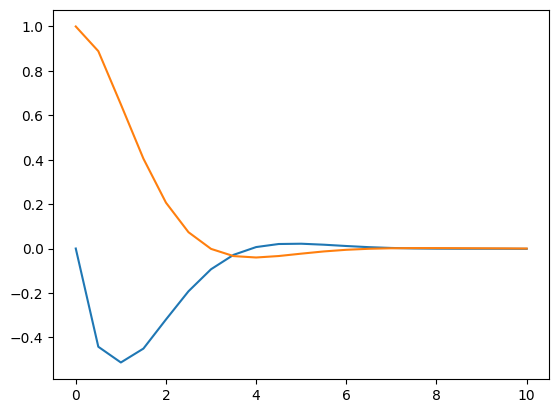

In [511]:
plt.figure()
plt.plot(t, sol.value(x).T)
plt.stairs(t, sol.value(u))
plt.legend(['x0 [m/s]', 'x1[m]'])
plt.xlabel('t [s]')
plt.show()